In [ ]:
# 필요 패키지 불러오기 
!pip install pandas_datareader
!pip install pmdarima

# 글꼴 불러오기
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 d

In [ ]:
import os
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns

plt.style.use('seaborn-whitegrid')
%matplotlib inline

import itertools

# data 변환 해주기 위함 
import datetime, dateutil

sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style('white')

In [ ]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data = pd.DataFrame(sm.datasets.get_rdataset("AirPassengers").data)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/time_series/rain_month.csv")

In [ ]:
data

,date,region,rain
0,2001-01-01,108,39.4
1,2001-02-01,108,45.7
2,2001-03-01,108,18.1
3,2001-04-01,108,12.3
4,2001-05-01,108,16.5
...,...,...,...
253,2022-02-01,108,4.7
254,2022-03-01,108,102.6
255,2022-04-01,108,20.4
256,2022-05-01,108,7.5


In [ ]:
# 날짜가 float 형식으로 들어가 있을 때 사용
# def yearfraction2datetime( yearfraction, startyear=0 ):
#     year = int( yearfraction ) + startyear
#     month = int( round( 12*( yearfraction - year) ) )
#     delta = dateutil.relativedelta.relativedelta( months=month )
#     date = datetime.datetime( year, 1, 1) + delta
#     return date


# dateutil.relativedelta.relativedelta( months=15 )

# data["time"] = data.time.map( yearfraction2datetime )

In [ ]:
data.dtypes

date       object
region      int64
rain      float64
dtype: object

In [ ]:
data['month'] = pd.to_datetime(data['date'])

In [ ]:
data.index = data['month']
data = data[['rain']]

In [ ]:
data

,rain
month,
2001-01-01,39.4
2001-02-01,45.7
2001-03-01,18.1
2001-04-01,12.3
2001-05-01,16.5
...,...
2022-02-01,4.7
2022-03-01,102.6
2022-04-01,20.4


Text(0.5, 1.0, 'Monthly precipitation in Seoul')

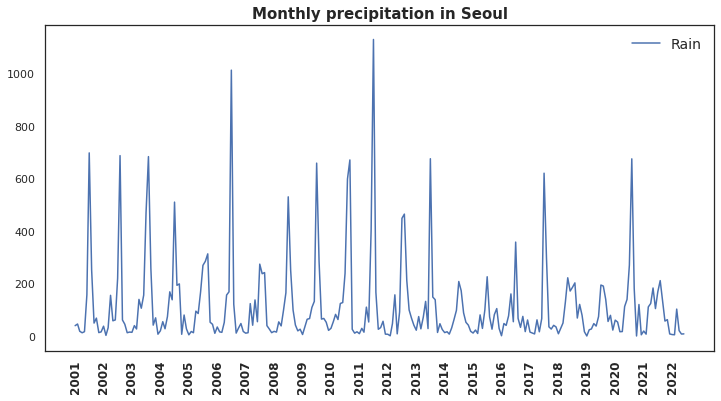

In [ ]:
# 원데이터 확인
# fig = data.plot()
plt.figure(figsize = (12,6))
plt.plot(data, label='Rain')
plt.xticks(data.iloc[np.arange(0, 258, step=12),:].index.tolist(), list(range(2001,2023)), size = 12, rotation = 90, fontweight = 'bold')
plt.legend(fontsize= 14)
plt.title("Monthly precipitation in Seoul", fontsize = 15, fontweight = 'bold')

# 3. Box-Jenkins ARIMA Procedure
* 3.1 Data Preprocessing
* 3.2 Identify Model to be Tentatively Entertainted
* 3.3 Estimate Parameters
* 3.4 Diagnosis Check
* 3.5 use Model to Forecast

## 3.1 Data Preprocessing

In [ ]:
# train, test 나누기 (2001-2020 : train, 2021- : test)
train_data = data.iloc[:240,:]
test_data = data.iloc[240:, :]
# 먼저 train, test 데이터 셋을 나누어 진행한다. 2001년부터 2020년까지 20개년의 월별 강수량 자료는 train data로, 2021 부터 월별 강수량 자료는 test data 로 나누었다.

Text(0.5, 1.0, 'Monthly precipitation in Seoul')

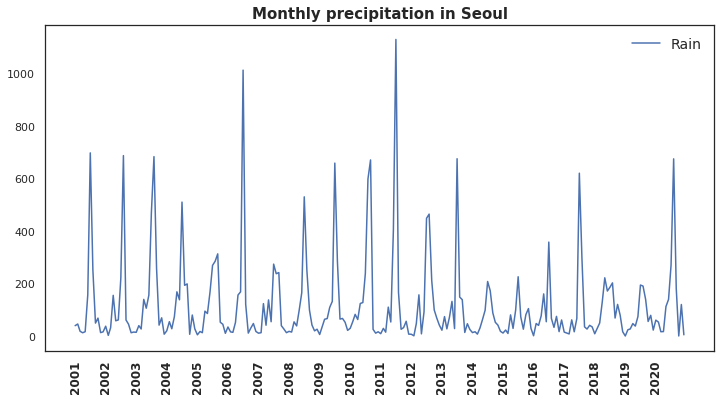

In [ ]:
# 원데이터 확인
# fig = data.plot()
plt.figure(figsize = (12,6))
plt.plot(train_data, label='Rain')
plt.xticks(train_data.iloc[np.arange(0, 240, step=12),:].index.tolist(), list(range(2001,2021)), size = 12, rotation = 90, fontweight = 'bold')
plt.legend(fontsize= 14)
plt.title("Monthly precipitation in Seoul", fontsize = 15, fontweight = 'bold')
# 현재 뚜렷한 추세를 보이고 있으며, 12개월 주기로 계절성 또한 띄는 것으로 보임
# python decompose 함수에서 주기 12로 지정하여 추세와 계절성을 좀 더 자세히 살펴보기로 함

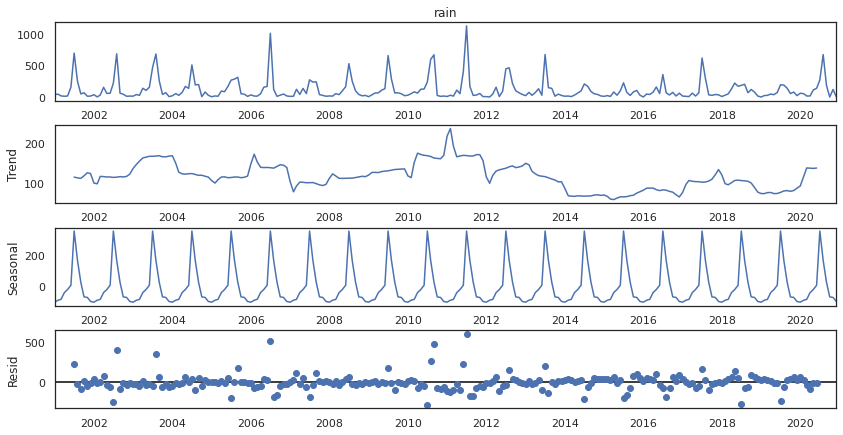

In [ ]:
# 계절성도 확인
# observed : 관측 데이터
# trend : 추세 여부
# seasonal : 계절성 확인
# resid : 잔차 확인
decomposition = sm.tsa.seasonal_decompose(train_data['rain'], model = 'additive', period = 12) #
fig = decomposition.plot()
fig.set_size_inches(12,6)
# fig.set_xticks(data.iloc[np.arange(0, 258, step=12),:].index.tolist(), list(range(2001,2023)), size = 12, rotation = 90, fontweight = 'bold')
plt.show()

# 추세는 보이지 않고, 계절성 년 주기로 뚜렷하게 보임
# 분산과 평균이 일정하지 않은 것으로 보이므로, 먼저 제곱근 변환 후, 계절성 차분(12) 실시

In [ ]:
train_data = np.log(train_data)

In [ ]:
# 계절성 차분
s_diff_train_data = train_data.copy()
s_diff_train_data = s_diff_train_data['rain'].diff(12)
s_diff_train_data = s_diff_train_data.dropna() # 차분하면 마지막 항이 결측치로 남기 때문에
print('### Raw Data ###')
print(train_data)
print('### Differenced Data ###')
print(s_diff_train_data)

### Raw Data ###
                rain
month               
2001-01-01  3.673766
2001-02-01  3.822098
2001-03-01  2.895912
2001-04-01  2.509599
2001-05-01  2.803360
...              ...
2020-08-01  6.515749
2020-09-01  5.201256
2020-10-01 -2.302585
2020-11-01  4.788325
2020-12-01  1.526056

[240 rows x 1 columns]
### Differenced Data ###
month
2002-01-01   -0.052095
2002-02-01   -2.946630
2002-03-01    0.554076
2002-04-01    2.534471
2002-05-01    1.257083
                ...   
2020-08-01    1.266097
2020-09-01    0.261043
2020-10-01   -6.318968
2020-11-01    0.421412
2020-12-01   -1.591894
Name: rain, Length: 228, dtype: float64


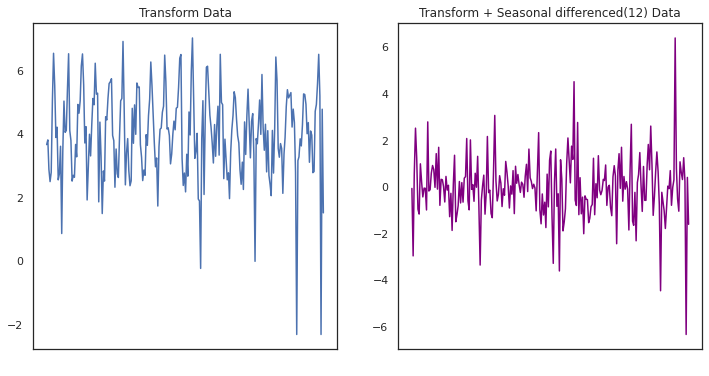

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(121)
plt.plot(train_data, label='Rain')
# plt.xticks(train_data.iloc[np.arange(0, 240, step=12),:].index.tolist(), list(range(2001,2021)), size = 12, rotation = 90, fontweight = 'bold')
# plt.legend(['Transform Data'], fontsize= 12)
plt.xticks(color='w')
plt.title("Transform Data", fontsize = 12)
plt.subplot(122)
plt.plot(s_diff_train_data, 'purple')
# plt.legend(['Transform + Sesonal(12) Differenced Data'], fontsize= 12, loc = "upper right")
# plt.xticks(data.iloc[np.arange(0, 240, step=12),:].index.tolist(), list(range(2001,2021)), size = 9, rotation = 90)
# plt.axis('off')
plt.title("Transform + Seasonal differenced(12) Data", fontsize = 12)
plt.xticks(color='w')

plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


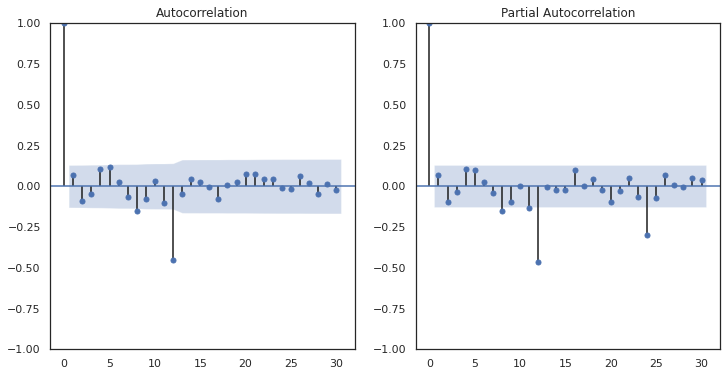

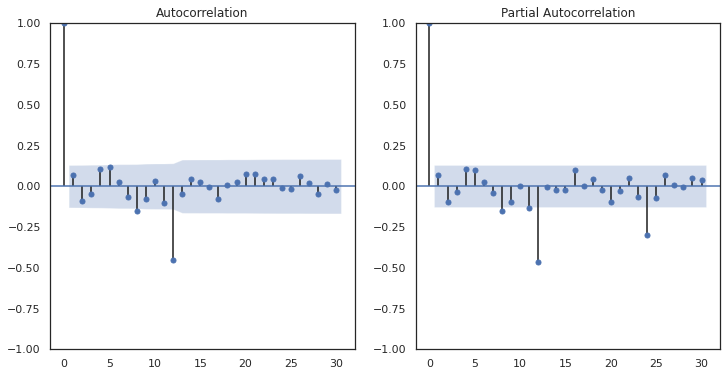

In [ ]:
# ACF + PACF plot
fig, axes = plt.subplots(1,2, figsize=(12,6)) # 4개의 ax를 가진 하나의 figure 생성

# axes[0].plot(s_diff_train_data, "purple")
# axes[0].legend(['Seasonal(12) Differenced Data'])
# axes[0].set_xticklabels(data.iloc[np.arange(0, 240, step=12),:].index.tolist(), list(range(2002,2022)), rotation = 90)
# # fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(s_diff_train_data.values.squeeze(), lags = 30, ax = axes[0])
sm.graphics.tsa.plot_pacf(s_diff_train_data.values.squeeze(), lags = 30, ax = axes[1])
# 1차 차분 후 자기상관함수를 그래프화 해보면 반복되는 패턴이 보이는데, 
# 이는 계절성을 가진 데이터의 전형적인 특징이다. 따라서, 계절적 차분을 추가적으로 진행한다.
# 본 데이터는 1년 주기로 계절성을 띄는 것을 보이므로, 12개월을 계절적 차분한다.

In [ ]:
# 단위근 검정
# adf test 를 통한 staionary 판단

# 참고 링크 : https://rfriend.tistory.com/694
## UDF for ADF test
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(s_diff_train_data.values)

#  귀무가설 (H0: 단위근(unit root)이 존재한다. 즉, 정상 시계열이 아니다)을 기각하고 대립가설 (H1: 단위근이 없다. 즉, 정상 시계열이다.) 
#  p-value 가 0.05 이하이므로, 귀무가설 기각, 따라서 정상 시계열 데이터로 판단된다. 

Results of Dickey-Fuller Test:
Test Statistic                -8.876798e+00
p-value                        1.351128e-14
#Lags Used                     1.100000e+01
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


In [ ]:
# kpss test
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(s_diff_train_data.values)


# p-value 가 0.1 로서 유의수준 0.05% 하에서 귀무가설 (H0: 정상 시계열이다) 를 채택하고, 대립가설 (H1: 정상 시계열이 아니다) 를 기각합니다.
# 두 가지 통계 test 에서도 모두 정상 시계열이라고 판단되므로, ACF 와 PACF graph 를 통해 적정한 seasonal ARIMA 모델을 적용해보고자 한다.

Results of KPSS Test:
Test Statistic           0.035991
p-value                  0.100000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


In [ ]:
model_opt = SARIMAX(train_data.values, order = (1,0,0), 
                    seasonal_order = (0,0,1,12))
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  240
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -429.796
Date:                              Fri, 17 Jun 2022   AIC                            865.592
Time:                                      17:29:55   BIC                            876.034
Sample:                                           0   HQIC                           869.800
                                              - 240                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9100      0.034     27.097      0.000       0.844       0.976
ma.S.L12       0.2205      0.083      2.651      0.008       0.057       0.384
sigma2         2.0821      0.143     14.559      0.000       1.802       2.362
===================================================================================
Ljung-Box (L1) (Q):                  27.99   Jarque-Bera (JB):               185.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.95   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
print(model_opt_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  240
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -429.796
Date:                              Fri, 17 Jun 2022   AIC                            865.592
Time:                                      17:29:55   BIC                            876.034
Sample:                                           0   HQIC                           869.800
                                              - 240                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9100      0.034     27.097      0.000       0.844       0.976
ma.S.L12       0.22

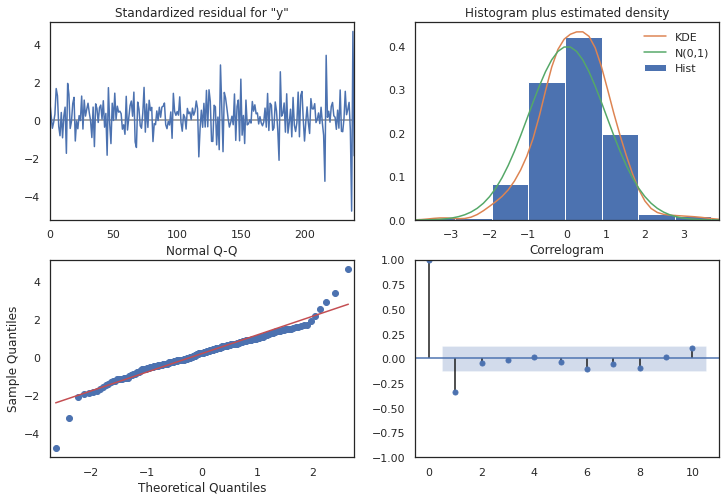

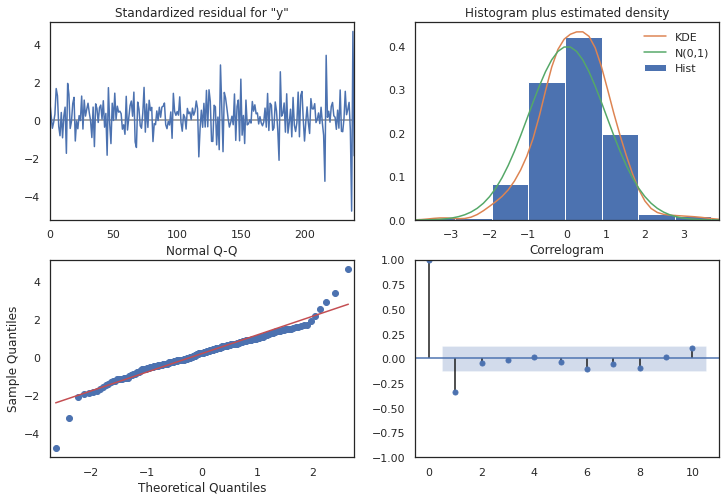

In [ ]:
model_opt_fit.plot_diagnostics(figsize = (12,8))

## 3.4.3 Diagnosis Check - auto_arima

In [ ]:
# ARIMA(9,1,0)(0,1,1)_12 
auto_arima_model = auto_arima(train_data, start_p=0, start_q=0,
                              max_p = 3, max_q = 3, m = 12, seasonal = True,
                              d = 0, D = 0, start_P = 0, start_Q = 0,
                              max_P = 3, max_Q = 3,
                              trace = True, 
                              error_action = 'ignore',
                              suppress_warnings = True,
                              stepwise = False)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=838.880, Time=0.03 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=797.833, Time=0.24 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=780.334, Time=1.04 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=746.526, Time=4.07 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=768.449, Time=1.44 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=696.022, Time=8.19 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=705.910, Time=18.12 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=734.482, Time=4.15 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=695.355, Time=9.88 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=698.447, Time=9.35 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=13.89 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=inf, Time=7.96 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=697.748, Time=11.77 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=693.856, Time=10.90 sec
 ARIMA(0,0,1)(0,0,

In [ ]:
print(auto_arima_model.summary())

                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                  240
Model:             SARIMAX(3, 0, [1, 2], 12)   Log Likelihood                -339.928
Date:                       Fri, 17 Jun 2022   AIC                            693.856
Time:                               17:35:23   BIC                            718.221
Sample:                                    0   HQIC                           703.674
                                       - 240                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0730      0.076      0.963      0.335      -0.076       0.222
ar.S.L12      -0.0317      0.222     -0.143      0.887      -0.467       0.

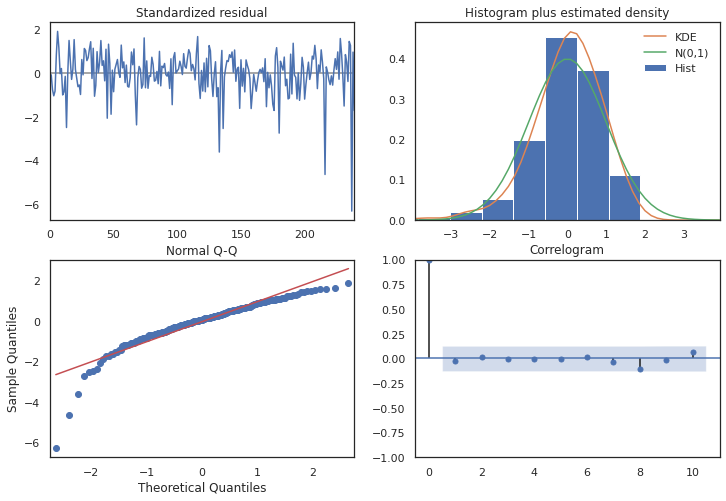

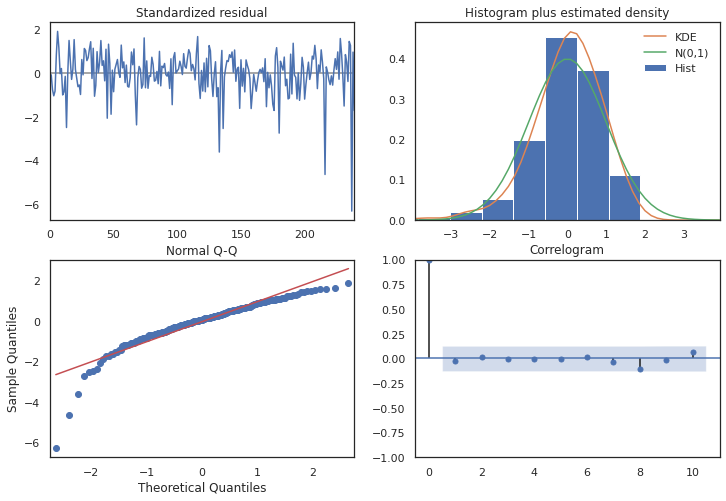

In [ ]:
auto_arima_model.plot_diagnostics(figsize = (12,8))

## 3.5.1 use model to forecast - ARIMA

In [ ]:
prediction = auto_arima_model.predict(len(test_data),return_conf_int = True, alpha = 0.05)
predicted_value = prediction[0]
predicted_ub = prediction[1][:,1]
predicted_lb = prediction[1][:,0]
predict_index = list(test_data.index)
r2 = r2_score(np.log(test_data).values, predicted_value)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


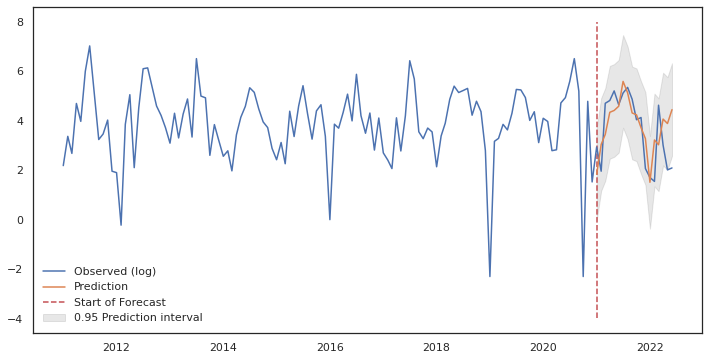

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(data.index[120:], np.log(data).values[120:], label = "Observed (log)")
ax.plot(predict_index, predicted_value, label = "Prediction")
ax.vlines(predict_index[0],-4,8,linestyle='--',color='r',label='Start of Forecast')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction interval')
ax.legend(loc='bottom left')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Unrecognized location 'top middle'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  import sys


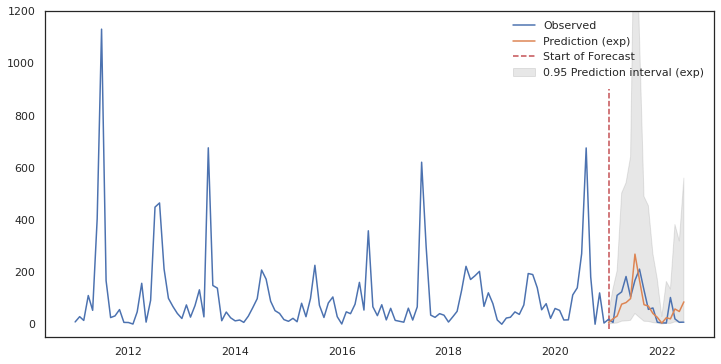

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(data.index[120:], data.values[120:], label = "Observed")
ax.plot(predict_index, np.exp(predicted_value), label = "Prediction (exp)")
ax.set_ylim((-50, 1200))
ax.vlines(predict_index[0],-20,900,linestyle='--',color='r',label='Start of Forecast')
ax.fill_between(predict_index, np.exp(predicted_lb), np.exp(predicted_ub), color = 'k', alpha = 0.1, label = '0.95 Prediction interval (exp)')
ax.legend(loc='top middle')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


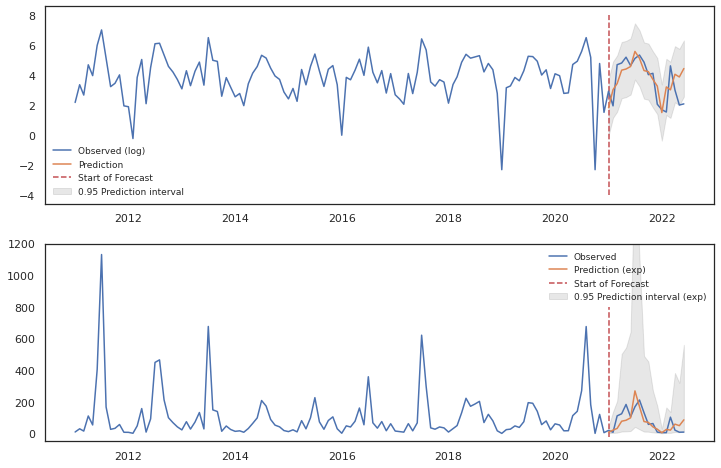

In [ ]:
fig, ax = plt.subplots(2,1,figsize = (12,8))
ax[0].plot(data.index[120:], np.log(data).values[120:], label = "Observed (log)")
ax[0].plot(predict_index, predicted_value, label = "Prediction")
ax[0].vlines(predict_index[0],-4,8,linestyle='--',color='r',label='Start of Forecast')
ax[0].fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction interval')
ax[0].legend(loc='bottom left', fontsize = 9)

# r2 = r2_score(test_data.values, np.exp(predicted_value))

ax[1].plot(data.index[120:], data.values[120:], label = "Observed")
ax[1].plot(predict_index, np.exp(predicted_value), label = "Prediction (exp)")
ax[1].set_ylim((-50, 1200))
ax[1].vlines(predict_index[0],-20,800,linestyle='--',color='r',label='Start of Forecast')
ax[1].fill_between(predict_index, np.exp(predicted_lb), np.exp(predicted_ub), color = 'k', alpha = 0.1, label = '0.95 Prediction interval (exp)')
ax[1].legend(loc='bottom left', fontsize = 9)

In [ ]:
r2 = r2_score(np.log(test_data).values, predicted_value)
mape = np.mean(np.abs(predicted_value - np.log(test_data).values) / np.abs(np.log(test_data).values)) *100
print(r2, mape)

r2 = r2_score(test_data.values, np.exp(predicted_value))
mape = np.mean(np.abs(np.exp(predicted_value) - test_data.values) / np.abs(test_data.values)) *100
print(r2, mape)

0.3201913521113202 52.31666626395558
0.3753256181529109 377.00491387082326


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


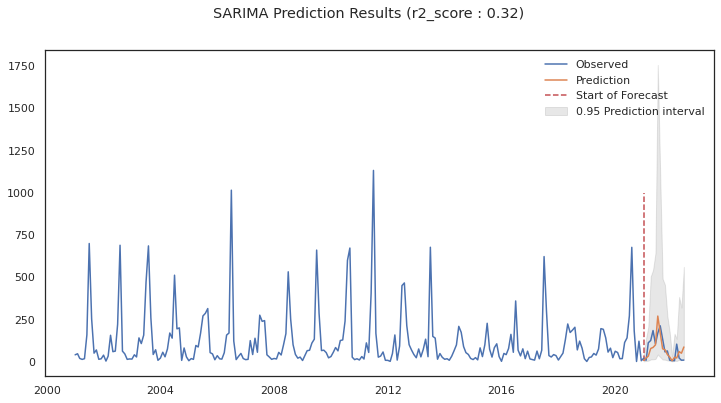

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(data.index, data.values, label = "Observed")
ax.plot(predict_index, np.exp(predicted_value), label = "Prediction")
ax.vlines(predict_index[0],0,1000,linestyle='--',color='r',label='Start of Forecast')
ax.fill_between(predict_index, np.exp(predicted_lb), np.exp(predicted_ub), color = 'k', alpha = 0.1, label = '0.95 Prediction interval')
ax.legend(loc='bottom left')
plt.suptitle(f'SARIMA Prediction Results (r2_score : {round(r2,2)})')
plt.show()